
このノートブックを実行するには、次の追加ライブラリが必要です。 Colab での実行は実験的なものであることに注意してください。問題がある場合は、Github の問題を報告してください。


In [ ]:
!pip install d2l==1.0.0-beta0



# 凸面性

:label: `sec_convexity`

凸性は、最適化アルゴリズムの設計において重要な役割を果たします。これは主に、このような状況ではアルゴリズムの分析とテストがはるかに簡単であるという事実によるものです。言い換えれば、凸型設定でもアルゴリズムのパフォーマンスが低い場合、通常はそれ以外の場合に優れた結果が得られることは期待できません。さらに、深層学習における最適化問題は一般に非凸型ですが、極小値付近では凸型の特性を示すことがよくあります。これにより、 :cite: `Izmailov.Podoprikhin.Garipov.ea.2018`などの魅力的な新しい最適化バリアントが生まれる可能性があります。


In [1]:
%matplotlib inline
import numpy as np
import torch
from mpl_toolkits import mplot3d
from d2l import torch as d2l


## 定義

凸解析の前に、*凸集合*と*凸関数*を定義する必要があります。これらは、機械学習に一般的に適用される数学的ツールにつながります。

### 凸集合

セットは凸性の基礎です。簡単に言うと、ベクトル空間内の集合 $\mathcal{X}$ は、 \mathcal{X}$ の任意の $a, b \について $a$ と $b$ を結ぶ線分も $\mathcal にある場合に*凸*です。 {X}$。数学用語で言うと、これは、すべての $\lambda \in [0, 1]$ に対して、

 $$\lambda a + (1-\lambda) b \in \mathcal{X} \text{ いつでも } a, b \in \mathcal{X}.$$

これは少し抽象的に聞こえます。 :numref: `fig_pacman`を考えてみましょう。最初のセットは、それに含まれていない線分が存在するため、凸ではありません。他の 2 つのセットにはそのような問題は発生しません。 

![](http://d2l.ai/_images/pacman.svg) :ラベル: `fig_pacman`

定義自体は、それを使用して何かを実行できない限り、特に役に立ちません。この場合、 :numref: `fig_convex_intersect`に示すように交差を確認できます。 $\mathcal{X}$ と $\mathcal{Y}$ が凸集合であると仮定します。すると $\mathcal{X} \cap \mathcal{Y}$ も凸になります。これを確認するには、任意の $a, b \in \mathcal{X} \cap \mathcal{Y}$ を考えてみましょう。 $\mathcal{X}$と$\mathcal{Y}$は凸なので、$a$と$b$を結ぶ線分は$\mathcal{X}$と$\mathcal{Y}$の両方に含まれます。そう考えると、それらは $\mathcal{X} \cap \mathcal{Y}$ にも含まれる必要があるため、定理が証明されます。 

![](../img/convex-intersect.svg) :label: `fig_convex_intersect`

この結果は少しの労力で強化できます。凸集合 $\mathcal{X} *i$ が与えられると、それらの積 $\cap* {i} \mathcal{X}_i$ は凸になります。逆が真ではないことを確認するには、2 つの素な集合 $\mathcal{X} \cap \mathcal{Y} = \emptyset$ を考えてみましょう。ここで $a \in \mathcal{X}$ と $b \in \mathcal{Y}$ を選択します。 $a$ と $b$ を結ぶ :numref: `fig_nonconvex`線分には、$\mathcal{X}$ にも $\mathcal{Y}$ にもない部分が含まれている必要があります。 X} \cap \mathcal{Y} = \emptyset$。したがって、線分は $\mathcal{X} \cup \mathcal{Y}$ にも存在せず、一般に凸集合の和集合は凸である必要がないことが証明されます。 

![](http://d2l.ai/_images/nonconvex.svg) :label: `fig_nonconvex`

通常、深層学習の問題は凸集合で定義されます。たとえば、実数の $d$ 次元ベクトルの集合である $\mathbb{R}^d$ は凸集合です (結局のところ、$\mathbb{R}^d$ の任意の 2 点間の直線です) $\mathbb{R}^d$ に残ります)。場合によっては、 ${\mathbf{x} | で定義される半径 $r$ のボールなど、長さが制限された変数を扱います。 \mathbf{x} \in \mathbb{R}^d \text{ と } |\mathbf{x}| \leq r}$。

### 凸関数

凸集合ができたので、*凸関数*$f$ を導入できます。凸集合 $\mathcal{X}$ が与え*られ*た場合、関数 $f: \mathcal{X} \to \mathbb{R}$ は、すべての $x, x&#39; \in \mathcal{X}$ と、我々が持っているすべての $\lambda \in [0, 1]$

 $$\lambda f(x) + (1-\lambda) f(x&#39;) \geq f(\lambda x + (1-\lambda) x&#39;).$$

これを説明するために、いくつかの関数をプロットし、どれが要件を満たしているかを確認してみましょう。以下では、凸関数と非凸関数の両方をいくつか定義します。


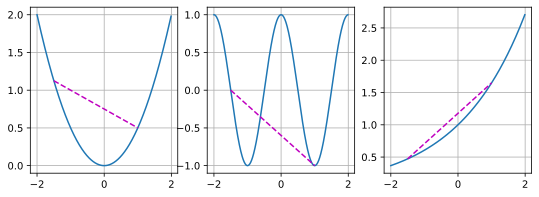

In [2]:
f = lambda x: 0.5 * x**2  # Convex
g = lambda x: torch.cos(np.pi * x)  # Nonconvex
h = lambda x: torch.exp(0.5 * x)  # Convex

x, segment = torch.arange(-2, 2, 0.01), torch.tensor([-1.5, 1])
d2l.use_svg_display()
_, axes = d2l.plt.subplots(1, 3, figsize=(9, 3))
for ax, func in zip(axes, [f, g, h]):
    d2l.plot([x, segment], [func(x), func(segment)], axes=ax)


予想どおり、コサイン関数は*非凸*ですが、放物線と指数関数は凸です。 $\mathcal{X}$ が凸集合であるという要件は、条件が意味をなすために必要であることに注意してください。そうしないと、$f(\lambda x + (1-\lambda) x&#39;)$ の結果が明確に定義されない可能性があります。

### ジェンセンの不等式

凸関数 $f$ が与えられた場合、最も有用な数学ツールの 1 つは*ジェンセンの不等式*です。これは、凸性の定義を一般化したものになります。

 $$\sum_i \alpha_i f(x_i) \geq f\left(\sum_i \alpha_i x_i\right) \text{ および } E_X[f(X)] \geq f\left(E_X[X]\right), $$ :eqlabel: `eq_jensens-inequality`

ここで、$\alpha_i$ は $\sum_i \alpha_i = 1$ のような非負の実数で、$X$ は確率変数です。言い換えれば、凸関数の期待値は、期待値の凸関数と同じです。通常、後者の方が単純な式です。最初の不等式を証明するために、凸性の定義を一度に合計の 1 つの項に繰り返し適用します。

ジェンセンの不等式の一般的な応用の 1 つは、より複雑な式をより単純な式で拘束することです。たとえば、部分的に観測された確率変数の対数尤度に関して応用することができます。つまり、私たちが使用するのは、

 $$E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X),$$

 $\int P(Y) P(X \mid Y) dY = P(X)$ なので。これは変分法で使用できます。ここで、$Y$ は通常、観測されていない確率変数、$P(Y)$ はそれがどのように分布するかの最良の推測、$P(X)$ は $Y$ を統合した分布です。たとえば、クラスタリングでは、$Y$ がクラスター ラベルになり、$P(X \mid Y)$ がクラスター ラベルを適用するときの生成モデルになります。

## プロパティ

凸関数には多くの便利な特性があります。よく使用されるものをいくつか以下に説明します。

### 局所的最小値は大域的最小値である

何よりもまず、凸関数の局所最小値は大域最小値でもあります。次のように矛盾によって証明できます。

凸集合 $\mathcal{X}$ 上で定義された凸関数 $f$ を考えてみましょう。 $x^{\ast} \in \mathcal{X}$ が局所最小値であるとします。小さな正の値 $p$ が存在するため、$x \in \mathcal{X}$ に対して $0 &lt; |x が満たされます。 - x^{\ast}| \leq p$ $f(x^{\ast}) &lt; f(x)$ があります。

局所最小値 $x^{\ast}$ が $f$ の大域最小値ではないと仮定します。 $f(x&#39;) &lt; f(x^{ となる \mathcal{X}$ に $x&#39; \in が存在します。 \ast})$。 $\lambda = 1 - \frac{p}{|x^{\ast} - x&#39;|}$ のような $\lambda \in [0, 1)$ も存在し、$0 &lt; |\lambda x^ になります。 {\ast} + (1-\lambda) x&#39; - x^{\ast}| \leq p$。

ただし、凸関数の定義によれば、

 $$\begin{aligned} f(\lambda x^{\ast} + (1-\lambda) x&#39;) &amp;\leq \lambda f(x^{\ast}) + (1-\lambda) f( x&#39;) \ &amp;&lt; \lambda f(x^{\ast}) + (1-\lambda) f(x^{\ast}) \ &amp;= f(x^{\ast}), \end{aligned }$$

これは、$x^{\ast}$ が極小値であるという記述と矛盾します。したがって、 $f(x&#39;) &lt; f(x^{\ast})$ となる $x&#39; \in \mathcal{X}$ は存在しません。局所最小値 $x^{\ast}$ は大域最小値でもあります。

たとえば、凸関数 $f(x) = (x-1)^2$ には $x=1$ に局所最小値があり、これは大域最小値でもあります。


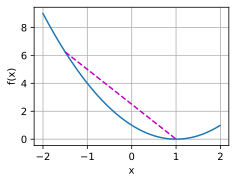

In [3]:
f = lambda x: (x - 1) ** 2
d2l.set_figsize()
d2l.plot([x, segment], [f(x), f(segment)], 'x', 'f(x)')


凸関数の極小値が大域極小値でもあるという事実は非常に便利です。機能を最小限にすれば「行き詰まる」ことがないということです。ただし、これは、グローバル最小値が複数存在できない、または存在する可能性さえあるという意味ではないことに注意してください。たとえば、関数 $f(x) = \mathrm{max}(|x|-1, 0)$ は、区間 $[-1, 1]$ にわたって最小値に達します。逆に、関数 $f(x) = \exp(x)$ は $\mathbb{R}$ で最小値に達しません。$x \to -\infty$ では $0$ に漸近しますが、 $x$ の場合、$f(x) = 0$。

### 以下の凸関数のセットは凸です

*以下の凸関数のセット*を使用して凸セットを簡単に定義できます。具体的には、凸集合 $\mathcal{X}$ 上で定義された凸関数 $f$ が与えられた場合、以下の集合

$$\mathcal{S}_b \stackrel{\mathrm{def}}{=} {x | x \in \mathcal{X} \text{ および } f(x) \leq b}$$

凸です。

これを早速証明してみましょう。任意の $x, x&#39; \in \mathcal{S}_b$ について、$\ である限り $\lambda x + (1-\lambda) x&#39; \in \mathcal{S}_b$ であることを示す必要があることを思い出してください。ラムダ \in [0, 1]$。 $f(x) \leq b$ と $f(x&#39;) \leq b$ なので、凸性の定義により、次のようになります。

 $$f(\lambda x + (1-\lambda) x&#39;) \leq \lambda f(x) + (1-\lambda) f(x&#39;) \leq b.$$

### 凸性と二次導関数

関数 $f: \mathbb{R}^n \rightarrow \mathbb{R}$ の二次導関数が存在するときはいつでも、$f$ が凸であるかどうかをチェックするのは非常に簡単です。 $f$ のヘッセ行列が正の半定値であるかどうかを確認するだけです: $\nabla^2f \succeq 0$、つまり、ヘッセ行列 $\nabla^2f$ を $\mathbf{H}$, $ で表します。 \mathbf{x}^\top \mathbf{H} \mathbf{x} \geq \mathbb{R}^n$ 内のすべての $\mathbf{x} \ は 0$ です。たとえば、関数 $f(\mathbf{x}) = \frac{1}{2} |\mathbf{x}|^2$ は、$\nabla^2 f = \mathbf{1}$ であるため、凸です。つまり、そのヘッセ行列は恒等行列です。

形式的には、2 回微分可能な 1 次元関数 $f: \mathbb{R} \rightarrow \mathbb{R}$ は、その 2 階導関数 $f&#39;&#39; \geq 0$ の場合にのみ凸になります。任意の 2 回微分可能な多次元関数 $f: \mathbb{R}^{n} \rightarrow \mathbb{R}$ の場合、そのヘッセ行列 $\nabla^2f \succeq 0$ の場合に限り凸になります。

まず、一次元の場合を証明する必要があります。 $f$ の凸性が $f&#39;&#39; \geq 0$ を意味することを確認するには、次の事実を使用します。

 $$\frac{1}{2} f(x + \epsilon) + \frac{1}{2} f(x - \epsilon) \geq f\left(\frac{x + \epsilon}{2} + \frac{x - \epsilon}{2}\right) = f(x).$$

二次導関数は有限差分の極限によって与えられるので、次のようになります。

 $$f&#39;&#39;(x) = \lim_{\epsilon \to 0} \frac{f(x+\epsilon) + f(x - \epsilon) - 2f(x)}{\epsilon^2} \geq 0 .$$

 $f&#39;&#39; \geq 0$ が $f$ が凸であることを意味することを確認するには、 $f&#39;&#39; \geq 0$ が $f&#39;$ が単調非減少関数であることを意味するという事実を使用します。 $a &lt; x &lt; b$ を $\mathbb{R}$ の 3 点とし、$x = (1-\lambda)a + \lambda b$ および $\lambda \in (0, 1)$ とします。平均値定理によれば、次のような $\alpha \in [a, x]$ と $\beta \in [x, b]$ が存在します。

 $$f&#39;(\alpha) = \frac{f(x) - f(a)}{xa} \text{ および } f&#39;(\beta) = \frac{f(b) - f(x)} {bx}.$$

単調性 $f&#39;(\beta) \geq f&#39;(\alpha)$ により、次のようになります。

 $$\frac{xa}{ba}f(b) + \frac{bx}{ba}f(a) \geq f(x).$$

 $x = (1-\lambda)a + \lambda b$ なので、次のようになります。

 $$\lambda f(b) + (1-\lambda)f(a) \geq f((1-\lambda)a + \lambda b),$$

したがって、凸性を証明します。

次に、多次元の場合を証明する前に補題が必要です。 $f: \mathbb{R}^n \rightarrow \mathbb{R}$ が凸であるのは、すべての $\mathbf{x}, \mathbf{ について、かつその場合に限ります。 y} \in \mathbb{R}^n$

 $$g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z) \mathbf{y}) \text{ where } z \in [0,1 ]$$

凸です。

 $f$ の凸性が $g$ が凸であることを意味することを証明するには、すべての $a, b, \lambda \in [0, 1]$ について次のことを示すことができます (したがって、 $0 \leq \lambda a + (1-\ラムダ) b \leq 1$)

 $$\begin{aligned} &amp;g(\lambda a + (1-\lambda) b)\ =&amp;f\left(\left(\lambda a + (1-\lambda) b\right)\mathbf{x} + \left(1-\lambda a - (1-\lambda) b\right)\mathbf{y} \right)\ =&amp;f\left(\lambda \left(a \mathbf{x} + (1-a) \mathbf{y}\right) + (1-\lambda) \left(b \mathbf{x} + (1-b) \mathbf{y}\right) \right)\ \leq&amp; \lambda f\left( a \mathbf{x} + (1-a) \mathbf{y}\right) + (1-\lambda) f\left(b \mathbf{x} + (1-b) \mathbf{y}\right ) \ =&amp; \lambda g(a) + (1-\lambda) g(b)。 \end{整列}$$

逆を証明するには、すべての $\lambda \in [0, 1]$ について次のことを示すことができます。

 $$\begin{aligned} &amp;f(\lambda \mathbf{x} + (1-\lambda) \mathbf{y})\ =&amp;g(\lambda \cdot 1 + (1-\lambda) \cdot 0)\ \leq&amp; \lambda g(1) + (1-\lambda) g(0) \ =&amp; \lambda f(\mathbf{x}) + (1-\lambda) f(\mathbf{y})。 \end{整列}$$

最後に、上記の補題と 1 次元の場合の結果を使用して、多次元の場合は次のように証明できます。多次元関数 $f: \mathbb{R}^n \rightarrow \mathbb{R}$ は、\mathbb{R} 内のすべての $\mathbf{x}、\mathbf{y} \ についてその場合にのみ凸になります。 ^n$ $g(z) \stackrel{\mathrm{def}}{=} f(z \mathbf{x} + (1-z) \mathbf{y})$、ここで $z \in [0, 1]$は凸です。 1 次元の場合によれば、これは $g&#39;&#39; = (\mathbf{x} - \mathbf{y})^\top \mathbf{H}(\mathbf{x} - \mathbf{ の場合にのみ成立します。 y}) \geq 0$ ($\mathbf{H} \stackrel{\mathrm{def}}{=} \nabla^2f$) for all $\mathbf{x}, \mathbf{y} \in \mathbb {R}^n$。これは、正の半定値行列の定義による $\mathbf{H} \succeq 0$ に相当します。

## 制約

凸最適化の優れた特性の 1 つは、制約を効率的に処理できることです。つまり、次の形式の*制約付き最適化*問題を解くことができます。

 $$\begin{aligned} \mathop{\mathrm{minimize~}}_{\mathbf{x}} &amp; f(\mathbf{x}) \ \text{ の対象 } &amp; c_i(\mathbf{x}) \leq 0 \text{ for all } i \in {1, \ldots, n}, \end{aligned}$$

ここで、$f$ は目的関数、関数 $c_i$ は制約関数です。これが何をするかを確認するには、$c_1(\mathbf{x}) = |\mathbf{x}|_2 - 1$ の場合を考えます。この場合、パラメータ $\mathbf{x}$ は単位ボールに制限されます。 2 番目の制約が $c_2(\mathbf{x}) = \mathbf{v}^\top \mathbf{x} + b$ の場合、これは半スペースにあるすべての $\mathbf{x}$ に対応します。両方の制約を同時に満たすことは、ボールのスライスを選択することになります。

### ラグランジュ

一般に、制約付きの最適化問題を解決することは困難です。これに対処する 1 つの方法は、かなり単純な直観による物理学に由来します。箱の中にボールが入っていると想像してください。ボールは最も低い場所まで転がり、重力とボックスの側面がボールに加える力とのバランスがとれます。つまり、目的関数 (つまり重力) の勾配は制約関数の勾配によって相殺されます (ボールは壁の「押し戻し」によってボックス内に留まる必要があります)。一部の制約はアクティブではない場合があることに注意してください。ボールに触れていない壁はボールに力を及ぼすことができません。

*ラグランジュ*$L$ の導出を省略すると、上記の推論は次の鞍点最適化問題によって表現できます。

 $$L(\mathbf{x}, \alpha_1, \ldots, \alpha_n) = f(\mathbf{x}) + \sum_{i=1}^n \alpha_i c_i(\mathbf{x}) \text { ここで } \alpha_i \geq 0.$$

ここで、変数 $\alpha_i$ ($i=1,\ldots,n$) は、制約が適切に適用されることを保証するいわゆる*ラグランジュ乗数*です。これらは、すべての $i$ に対して $c_i(\mathbf{x}) \leq 0$ となるのに十分な大きさが選択されます。たとえば、$c_i(\mathbf{x}) &lt; 0$ である $\mathbf{x}$ の場合、当然ながら $\alpha_i = 0$ が選択されます。さらに、これは鞍点最適化問題であり、すべての $\alpha_i$ に関して $L$*を最大化し*、同時に $\mathbf{x}$ に関して*最小化する*必要があります。関数 $L(\mathbf{x}, \alpha_1, \ldots, \alpha_n)$ に到達する方法を説明する文献が豊富にあります。私たちの目的のためには、$L$ の鞍点が元の制約付き最適化問題が最適に解決される場所であることを知っていれば十分です。

### 罰則

制約付き最適化問題を少なくとも*近似的*に満足させる 1 つの方法は、ラグランジュ $L$ を適応させることです。 $c_i(\mathbf{x}) \leq 0$ を満たすのではなく、単純に $\alpha_i c_i(\mathbf{x})$ を目的関数 $f(x)$ に追加します。これにより、制約に大きく違反することがなくなります。

実際、私たちはずっとこのトリックを使ってきました。 :numref: `sec_weight_decay`での重みの減衰を考えてみましょう。その中で、$\frac{\lambda}{2} |\mathbf{w}|^2$ を目的関数に追加して、$\mathbf{w}$ が大きくなりすぎないようにします。制約付き最適化の観点からは、これにより、ある半径 $r$ に対して $|\mathbf{w}|^2 - r^2 \leq 0$ が保証されることがわかります。 $\lambda$ の値を調整すると、$\mathbf{w}$ のサイズを変更できます。

一般に、ペナルティを追加することは、おおよその制約を満たすことを保証する良い方法です。実際には、これは正確な満足よりもはるかに堅牢であることがわかります。さらに、非凸問題の場合、凸の場合に正確なアプローチを非常に魅力的なものにする特性 (最適性など) の多くはもはや当てはまりません。

### 予測

制約を満たすための代替戦略は投影です。繰り返しますが、以前、 :numref: `sec_rnn-scratch`でグラデーション クリッピングを扱うときなどに遭遇しました。そこでは、グラデーションの長さが $\theta$ によって制限されることを確認しました。

 $$\mathbf{g} \leftarrow \mathbf{g} \cdot \mathrm{min}(1, \theta/|\mathbf{g}|).$$

これは、$\mathbf{g}$ を半径 $\theta$ の球に*投影した*ものであることがわかります。より一般的には、凸集合 $\mathcal{X}$ 上の射影は次のように定義されます。

 $$\mathrm{Proj} *\mathcal{X}(\mathbf{x}) = \mathop{\mathrm{argmin}}* {\mathbf{x}&#39; \in \mathcal{X}} |\mathbf{x} - \mathbf{x}&#39;|,$$

これは $\mathcal{X}$ 内で $\mathbf{x}$ に最も近い点です。

![](http://d2l.ai/_images/projections.svg) :label: `fig_projections`

投影の数学的定義は少し抽象的に聞こえるかもしれません。 :numref: `fig_projections`もう少し明確に説明されています。その中には、円とひし形の 2 つの凸セットがあります。両方のセット内の点 (黄色) は、投影中に変更されません。両方のセットの外側の点 (黒) は、元の点 (黒) に最も近いセット内の点 (赤) に投影されます。 $\ell_2$ ボールの場合、方向は変更されませんが、ダイヤモンドの場合に見られるように、一般にそうする必要はありません。

凸投影の用途の 1 つは、スパースな重みベクトルを計算することです。この場合、重みベクトルを $\ell_1$ ボールに投影します。これは、 :numref: `fig_projections`のダイヤモンドの場合の一般化バージョンです。

## まとめ

深層学習のコンテキストでは、凸関数の主な目的は、最適化アルゴリズムを動機付け、アルゴリズムを詳細に理解するのに役立つことです。以下では、それに応じて勾配降下法と確率的勾配降下法をどのように導出できるかを見ていきます。
- 凸集合の交点は凸です。労働組合はそうではありません。
- 凸関数の期待値は、期待値の凸関数と同じです (ジェンセンの不等式)。
-  2 回微分可能関数は、そのヘッセ行列 (2 次導関数の行列) が正の半正定値である場合に限り、凸関数となります。
- 凸制約はラグランジュ関数を介して追加できます。実際には、目的関数にペナルティを付けて単純に追加することもできます。
- 投影は、元の点に最も近い凸セット内の点にマッピングされます。

## 演習
1. セット内の点の間にすべての線を描画し、その線が含まれているかどうかを確認することによって、セットの凸性を検証したいとします。<ol><li>境界上の点のみをチェックするだけで十分であることを証明してください。
1. セットの頂点のみをチェックするだけで十分であることを証明します。

[ディスカッション](https://discuss.d2l.ai/t/350)
